In [2]:
import numpy as np
import mediapipe
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from scipy.spatial import distance
from tabulate import tabulate

In [3]:
%%time

dict_list = []
for entry in os.scandir("./pose_data_parrot_stage"):
    if os.path.isfile(entry):
        dict_list.append([entry.name[:-4],np.load(entry.path, allow_pickle=True).item()])

<IPython.core.display.Javascript object>

Wall time: 47.7 s


In [4]:
# calculate the mean point for every frame
def meanor(landmark_dict):
    x_list = []
    y_list = []
    for value in landmark_dict.values():
        x = value.x
        y = value.y
        x_list.append(x)
        y_list.append(y)
        
    xm = np.mean(x_list)
    ym = np.mean(y_list)
    return [x,y]

In [5]:
# stack all cordinates in a list

def cord_extractor(case_data):
    x_list = []
    y_list = []
    
    for value in case_data.values():
        if value == 0:
            continue
        else:
            x = abs(round(meanor(value)[0] * 640))
            y = abs(round(meanor(value)[1] * 480))
            x_list.append(x)
            y_list.append(y)
            
    y_list = [2*(240-temp) + temp for temp in y_list]
    
    return(x_list, y_list)

In [114]:
# +----+----+----+----+
# | 12 | 13 | 14 | 15 |
# +----+----+----+----+
# |  8 |  9 | 10 | 11 |
# +----+----+----+----+
# |  4 |  5 |  6 |  7 |
# +----+----+----+----+
# |  0 |  1 |  2 |  3 |
# +----+----+----+----+


def point_classification(x,y):
    if x <= 640/4 and x >= 0 and y >= 0 and y <= 480/4:
        return 0
    elif x > 640/4 and x <= 640/2 and y <= 480/4 and y >= 0:
        return 1
    elif x > 640/2 and x <= 3*640/4 and y <= 480/4 and y >= 0:
        return 2
    elif x > 3*640/4 and x <= 640 and y <= 480/4 and y >= 0:
        return 3
    
    if x <= 640/4 and x >= 0 and y > 480/4 and y <= 480/2:
        return 4
    elif x > 640/4 and x <= 640/2 and y > 480/4 and y <= 480/2:
        return 5
    elif x > 640/2 and x <= 3*640/4 and y > 480/4 and y <= 480/2:
        return 6
    elif x > 3*640/4 and x <= 640 and y > 480/4 and y <= 480/2:
        return 7
    
    if x <= 640/4 and x >= 0 and y > 480/2 and y <= 3*480/4:
        return 8
    elif x > 640/4 and x <= 640/2 and y > 480/2 and y <= 3*480/4:
        return 9
    elif x > 640/2 and x <= 3*640/4 and y > 480/2 and y <= 3*480/4:
        return 10
    elif x > 3*640/4 and x <= 640 and y > 480/2 and y <= 3*480/4:
        return 11
    
    if x <= 640/4 and x >= 0 and y > 3*480/4 and y <= 480 and y >= 0:
        return 12
    elif x > 640/4 and x <= 640/2 and y > 3*480/4 and y <= 480 and y >= 0:
        return 13
    elif x > 640/2 and x <= 3*640/4 and y > 3*480/4 and y <= 480 and y >= 0:
        return 14
    elif x > 3*640/4 and x <= 640 and y > 3*480/4 and y <= 480 and y >= 0:
        return 15
    
    else:
        return -1

In [119]:
def id_vector_constractor(a, b):
    output = np.zeros(16)
    if len(a) == len(b):
        for i in range(len(a)):
            if i == 0:
                output[point_classification(a[i], b[i])] += 1
            else:
                if point_classification(a[i-1], b[i-1]) != point_classification(a[i], b[i]):
                    output[point_classification(a[i], b[i])] += 1
                else:
                    output[point_classification(a[i], b[i])] += 0
            
    else:
        return 0
    
    output[np.argwhere(output != 0)] = 1
    return output

In [133]:
def move_vector_constractor(a, b):
    output = np.zeros(16)
    if len(a) == len(b):
        for i in range(len(a)):
            if i == 0:
                output[point_classification(a[i], b[i])] += 1
            else:
                if point_classification(a[i-1], b[i-1]) != point_classification(a[i], b[i]):
                    output[point_classification(a[i], b[i])] += 1
                else:
                    output[point_classification(a[i], b[i])] += 0
            
    else:
        return 0
    
    return output

In [120]:
def main_vector_constractor(a, b):
    output = np.zeros(16)
    if len(a) == len(b):
        for i in range(len(a)):
            output[point_classification(a[i], b[i])] += 1
    else:
        return 0
    
    
    return output

In [134]:
id_vector = []
main_vector = []
move_vector = []
table = []

for i in range(len(dict_list)):
    case_name = dict_list[i][0]
    case_data = dict_list[i][1]
    
    x_stack, y_stack = cord_extractor(case_data)
    
    id_vector.append([case_name,id_vector_constractor(x_stack, y_stack)])
    main_vector.append([case_name,main_vector_constractor(x_stack, y_stack)])
    move_vector.append([case_name,move_vector_constractor(x_stack, y_stack)])
    
#     x1 = np.percentile(x_stack,25)
#     x2 = np.percentile(x_stack,75)
#     y1 = np.percentile(y_stack,25)
#     y2 = np.percentile(y_stack,75)
    
#     rect=mpatches.Rectangle((x1,y1),x2-x1,y2-y1, 
#                         fill = False,
#                         color = "purple",
#                         linewidth = 3)
    
    
#     x_mean = np.mean(x_stack)
#     y_mean = np.mean(y_stack)
    
#     r = np.sqrt(np.std(x_stack)**2 + np.std(y_stack)**2)
#     theta = np.linspace(0, 2*np.pi, 100)
#     X = r*np.cos(theta) + x_mean
#     Y = r*np.sin(theta) + y_mean
    
#     S_rect = (x2 - x1)*(y2 - y1)
#     S_circ = np.pi * r**2
#     table.append([case_name, S_rect, S_circ])
    
    
#     plt.plot(X,Y)
    
#     plt.scatter(x_stack, y_stack, color='k', marker='.')
#     plt.scatter(x_mean, y_mean, s = 300, color='r', marker='*')
    
#     plt.axvline(x=0, color='r', linestyle='--')
#     plt.axvline(x=640 / 4, color='g', linestyle='--')
#     plt.axvline(x=2 *  640 / 4, color='g', linestyle='--')
#     plt.axvline(x=3 * 640 / 4, color='g', linestyle='--')
#     plt.axvline(x=640, color='r', linestyle='--')
    
#     plt.axhline(y=0, color='r', linestyle='--')
#     plt.axhline(y=480/4, color='g', linestyle='--')
#     plt.axhline(y=2 * 480/4, color='g', linestyle='--')
#     plt.axhline(y=3 * 480/4, color='g', linestyle='--')
#     plt.axhline(y=480, color='r', linestyle='--')
    
#     plt.title(case_name)
#     plt.gca().add_patch(rect)
# #     plt.xlim([0, 640])
# #     plt.ylim([0, 480])
#     plt.show()
    
    
# print(tabulate(table, headers=["name", "S_rect", "S_circ"], tablefmt='grid'))

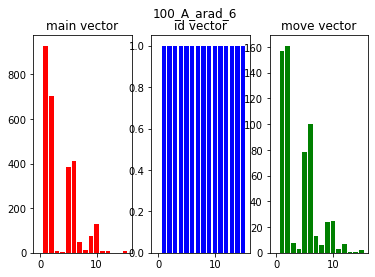

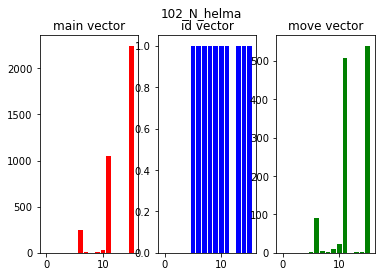

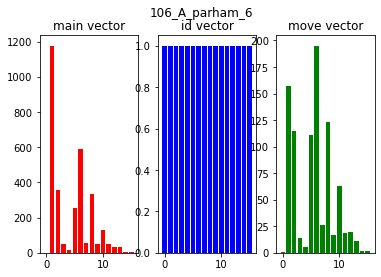

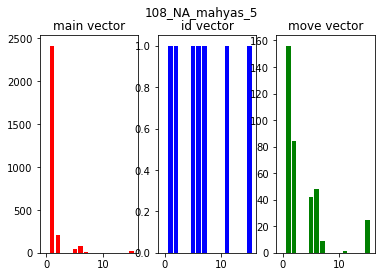

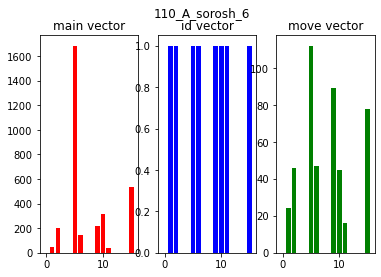

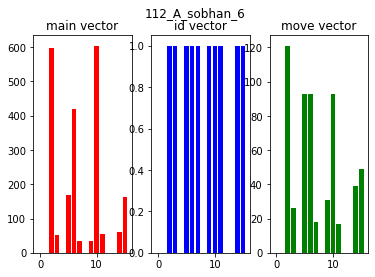

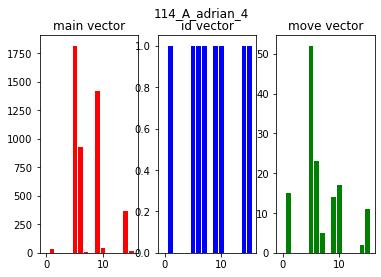

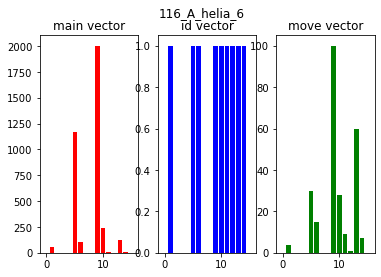

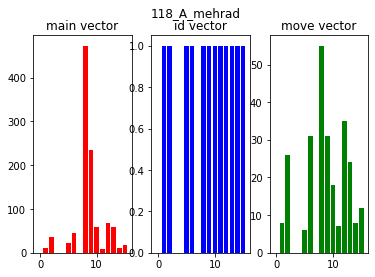

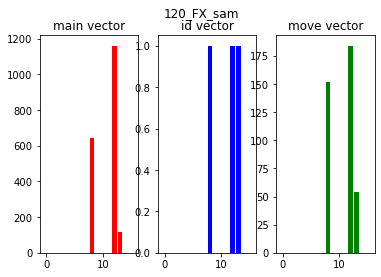

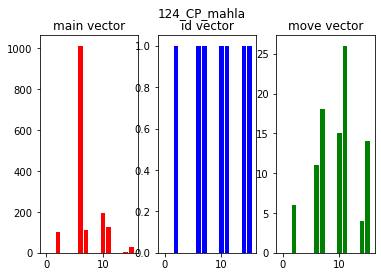

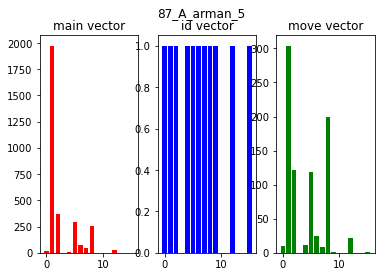

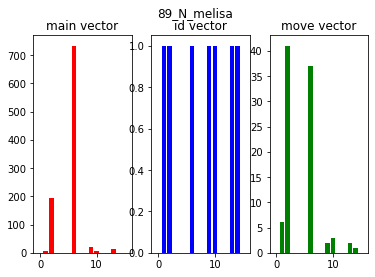

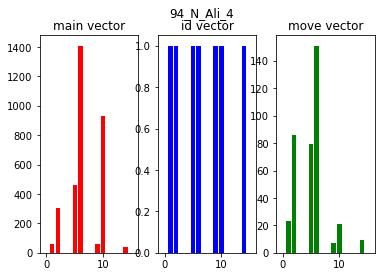

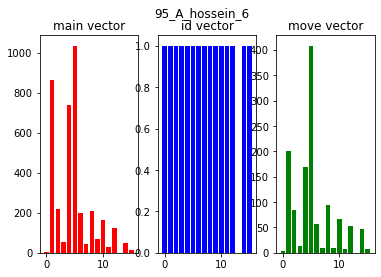

In [135]:
for i in range(len(id_vector)):
    x_bar = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    fig, axs = plt.subplots(nrows=1, ncols=3)
    axs[0].bar(x_bar, main_vector[i][1], color ='red',width = 0.8)
    axs[0].set_title('main vector')
    axs[1].bar(x_bar, id_vector[i][1], color ='blue',width = 0.8)
    axs[1].set_title('id vector')
    axs[2].bar(x_bar, move_vector[i][1], color ='green',width = 0.8)
    axs[2].set_title('move vector')
    fig.suptitle(main_vector[i][0])
    plt.show()

In [136]:
id_n = []
id_a = []
id_o = []

for data in id_vector:
    if data[0].find("_A_") > -1:
        id_a.append(data)
    elif data[0].find("_N_") > -1:
        id_n.append(data)
    else:
        id_o.append(data)
        
        
main_n = []
main_a = []
main_o = []

for data in main_vector:
    if data[0].find("_A_") > -1:
        main_a.append(data)
    elif data[0].find("_N_") > -1:
        main_n.append(data)
    else:
        main_o.append(data)
        
        
move_n = []
move_a = []
move_o = []

for data in move_vector:
    if data[0].find("_A_") > -1:
        move_a.append(data)
    elif data[0].find("_N_") > -1:
        move_n.append(data)
    else:
        move_o.append(data)

In [137]:
id_a_mean = np.mean( [id_a[i][1] for i in range(len(id_a))] , axis = 0)
id_n_mean = np.mean( [id_n[i][1] for i in range(len(id_n))] , axis = 0)
id_o_mean = np.mean( [id_o[i][1] for i in range(len(id_o))] , axis = 0)

main_a_mean = np.mean( [main_a[i][1] for i in range(len(main_a))] , axis = 0)
main_n_mean = np.mean( [main_n[i][1] for i in range(len(main_n))] , axis = 0)
main_o_mean = np.mean( [main_o[i][1] for i in range(len(main_o))] , axis = 0)

move_a_mean = np.mean( [move_a[i][1] for i in range(len(move_a))] , axis = 0)
move_n_mean = np.mean( [move_n[i][1] for i in range(len(move_n))] , axis = 0)
move_o_mean = np.mean( [move_o[i][1] for i in range(len(move_o))] , axis = 0)

In [138]:
id_table = []

for data in id_vector:
    name = data[0]
    matrix = data[1]
    SMA_id = (distance.cosine(id_a_mean ,matrix) -1) *-1
    SMN_id = (distance.cosine(id_n_mean ,matrix) -1) *-1
    SMO_id = (distance.cosine(id_o_mean ,matrix) -1) *-1
    
    column = [name, SMA_id, SMN_id, SMO_id]
    id_table.append(column)

print("id vector analysis")    
print(tabulate(id_table, headers=['Name', 'id SMA', 'id SMN', 'id SMO'], tablefmt='grid'))


main_table = []

for data in main_vector:
    name = data[0]
    matrix = data[1]
    SMA_main = (distance.cosine(main_a_mean ,matrix) -1) *-1
    SMN_main = (distance.cosine(main_n_mean ,matrix) -1) *-1
    SMO_main = (distance.cosine(main_o_mean ,matrix) -1) *-1
    
    column = [name, SMA_main, SMN_main, SMO_main]
    main_table.append(column)

print("main vector analysis")    
print(tabulate(main_table, headers=['Name', 'main SMA', 'main SMN', 'main SMO'], tablefmt='grid'))


move_table = []

for data in move_vector:
    name = data[0]
    matrix = data[1]
    SMA_move = (distance.cosine(move_a_mean ,matrix) -1) *-1
    SMN_move = (distance.cosine(move_n_mean ,matrix) -1) *-1
    SMO_move = (distance.cosine(move_o_mean ,matrix) -1) *-1
    
    column = [name, SMA_move, SMN_move, SMO_move]
    move_table.append(column)

print("move vector analysis")    
print(tabulate(move_table, headers=['Name', 'move SMA', 'move SMN', 'move SMO'], tablefmt='grid'))

id vector analysis
+-----------------+----------+----------+----------+
| Name            |   id SMA |   id SMN |   id SMO |
+=================+==========+==========+==========+
| 100_A_arad_6    | 0.961251 | 0.828079 | 0.844737 |
+-----------------+----------+----------+----------+
| 102_N_helma     | 0.839254 | 0.845154 | 0.791155 |
+-----------------+----------+----------+----------+
| 106_A_parham_6  | 0.958373 | 0.801784 | 0.817913 |
+-----------------+----------+----------+----------+
| 108_NA_mahyas_5 | 0.752326 | 0.606092 | 0.872872 |
+-----------------+----------+----------+----------+
| 110_A_sorosh_6  | 0.84709  | 0.803175 | 0.748455 |
+-----------------+----------+----------+----------+
| 112_A_sobhan_6  | 0.862567 | 0.802897 | 0.791155 |
+-----------------+----------+----------+----------+
| 114_A_adrian_4  | 0.834058 | 0.85042  | 0.680414 |
+-----------------+----------+----------+----------+
| 116_A_helia_6   | 0.823218 | 0.846327 | 0.6415   |
+-----------------+--------

In [142]:
table = []

for i in range(len(id_table)):
    [name, SMA_id, SMN_id, SMO_id] = id_table[i]
    [name, SMA_main, SMN_main, SMO_main] = main_table[i]
    [name, SMA_move, SMN_move, SMO_move] = move_table[i]
    
    table.append([name,
                  np.average([SMA_id, SMA_main, SMA_move], weights=[10,5,4]),
                  np.average([SMN_id, SMN_main, SMN_move], weights=[10,5,4]),
                  np.average([SMO_id, SMO_main, SMO_move], weights=[10,5,4]),
                 ])
    
print(tabulate(table, headers=['Name', 'mean SMA', 'mean SMN', 'mean SMO'], tablefmt='grid'))

+-----------------+------------+------------+------------+
| Name            |   mean SMA |   mean SMN |   mean SMO |
+=================+============+============+============+
| 100_A_arad_6    |   0.899265 |   0.595313 |   0.775638 |
+-----------------+------------+------------+------------+
| 102_N_helma     |   0.500367 |   0.841705 |   0.471494 |
+-----------------+------------+------------+------------+
| 106_A_parham_6  |   0.89327  |   0.597494 |   0.82184  |
+-----------------+------------+------------+------------+
| 108_NA_mahyas_5 |   0.701361 |   0.397662 |   0.807865 |
+-----------------+------------+------------+------------+
| 110_A_sorosh_6  |   0.806989 |   0.650834 |   0.489229 |
+-----------------+------------+------------+------------+
| 112_A_sobhan_6  |   0.745604 |   0.706192 |   0.562768 |
+-----------------+------------+------------+------------+
| 114_A_adrian_4  |   0.822643 |   0.615196 |   0.469083 |
+-----------------+------------+------------+-----------

In [14]:
def coverage(data_dict):
    output = np.zeros(16)
    
    x, y = cord_extractor(data_dict)
    for i in range(len(x)):
        output[point_cat(x[i], y[i])] += 1
        
    output = output / len(x)
    
    
    return output

In [15]:
np.argsort(coverage(dict_list[0][1]))

array([ 0, 13, 14,  4, 11, 12, 15,  3,  8,  7,  9, 10,  5,  6,  2,  1],
      dtype=int64)

In [16]:
table = []
for i in range(len(dict_list)):
    case_name = dict_list[i][0]
    case_data = dict_list[i][1]
    percentage = coverage(case_data) * 100
    table.append([case_name,percentage[1],percentage[2],percentage[5],percentage[6],percentage[9],percentage[10]])
    
print(tabulate(table, headers=['Name', 'area 1', 'area 2', 'area 5', 'area 6', 'area 9', 'area 10'], tablefmt='grid'))

+-----------------+-----------+----------+------------+----------+------------+-----------+
| Name            |    area 1 |   area 2 |     area 5 |   area 6 |     area 9 |   area 10 |
+=================+===========+==========+============+==========+============+===========+
| 100_A_arad_6    | 33.9671   | 25.7404  | 14.0402    | 15.1371  |  2.77879   |  4.68007  |
+-----------------+-----------+----------+------------+----------+------------+-----------+
| 102_N_helma     |  0        |  0       |  0.0278552 |  6.82451 |  0.306407  |  0.724234 |
+-----------------+-----------+----------+------------+----------+------------+-----------+
| 106_A_parham_6  | 37.4483   | 11.3904  |  8.11327   | 18.8037  |  1.65447   |  4.04073  |
+-----------------+-----------+----------+------------+----------+------------+-----------+
| 108_NA_mahyas_5 | 86.7457   |  7.57902 |  1.68822   |  2.72989 |  0         |  0        |
+-----------------+-----------+----------+------------+----------+------------+-